In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
from pathlib import Path
from shapely.geometry import Point, LineString
from pprint import pprint
from matplotlib import animation

import hydromt
from hydromt.log import setuplog
from hydromt_sfincs import SfincsModel, utils

# %matplotlib ipympl

logger = setuplog("prepare data catalog", log_level=10)

2024-04-11 11:16:55,452 - prepare data catalog - log - INFO - HydroMT version: 0.9.4


### 1. Initialize SfincsModel class, set data library and output folder:

In [2]:
data_libs = [
    Path(r"data/1_static/data_static_tana.yml"),
    Path(r"data/2_forcing/data_forcing.yml"),
]
model_root = Path(r"model/base_garissa")

data_catalog = hydromt.DataCatalog(data_libs=data_libs, logger=logger)

model = SfincsModel(root=model_root, data_libs=data_libs, mode="w+", logger=logger)

2024-04-11 11:16:55,479 - prepare data catalog - data_catalog - INFO - Parsing data catalog from data\1_static\data_static_tana.yml
2024-04-11 11:16:55,494 - prepare data catalog - data_catalog - INFO - Parsing data catalog from data\2_forcing\data_forcing.yml
2024-04-11 11:16:55,570 - prepare data catalog - data_catalog - INFO - Parsing data catalog from data\1_static\data_static_tana.yml
2024-04-11 11:16:55,583 - prepare data catalog - data_catalog - INFO - Parsing data catalog from data\2_forcing\data_forcing.yml
2024-04-11 11:16:55,586 - prepare data catalog - model_api - WARNING - Model dir already exists and files might be overwritten: c:\Users\pjdeb\OneDrive\Documenten\Universiteit\CT 5\MDP\Git\MDP\SFINCS\model\base_garissa\gis.
2024-04-11 11:16:55,587 - prepare data catalog - log - DEBUG - Appending log messages to file c:\Users\pjdeb\OneDrive\Documenten\Universiteit\CT 5\MDP\Git\MDP\SFINCS\model\base_garissa\hydromt.log.
2024-04-11 11:16:55,588 - prepare data catalog - model_a

### 2. Configure the time for which the model runs

In [ ]:
model.setup_config(
    **{
        "tref":     "20231001 000000",
        "tstart":   "20231001 000000",
        "tstop":    "20231101 000000",
    }
)

print(model.config)

### 3. Specify characteristics of the wanted grid and generate grid:

Region file found?  True
2024-04-11 11:16:55,615 - prepare data catalog - geodataframe - INFO - Reading  vector data from data\1_static\regions\region_garissa_5km_buffer.geojson
2024-04-11 11:16:55,728 - prepare data catalog - basin_mask - DEBUG - Parsed region (kind=geom): {'geom': 'GeoDataFrame [4402409.89783  -63608.17479 4423462.84213  -39354.37785] (crs = EPSG:3857)'}
{'mmax': 106, 'nmax': 122, 'dx': 200, 'dy': 200, 'x0': 4402410.0, 'y0': -63608.0, 'rotation': 0, 'latitude': 0.0, 'tref': datetime.datetime(2010, 2, 1, 0, 0), 'tstart': datetime.datetime(2010, 2, 1, 0, 0), 'tstop': datetime.datetime(2010, 2, 2, 0, 0), 'tspinup': 60.0, 'dtout': 3600.0, 'dthisout': 600.0, 'dtrstout': 0.0, 'dtmaxout': 86400, 'trstout': -999.0, 'dtwnd': 1800.0, 'alpha': 0.5, 'theta': 1.0, 'huthresh': 0.01, 'manning': 0.04, 'manning_land': 0.04, 'manning_sea': 0.02, 'rgh_lev_land': 0.0, 'zsini': 0.0, 'qinf': 0.0, 'rhoa': 1.25, 'rhow': 1024.0, 'dtmax': 60.0, 'advection': 1, 'baro': 0, 'pavbnd': 0, 'gapres'

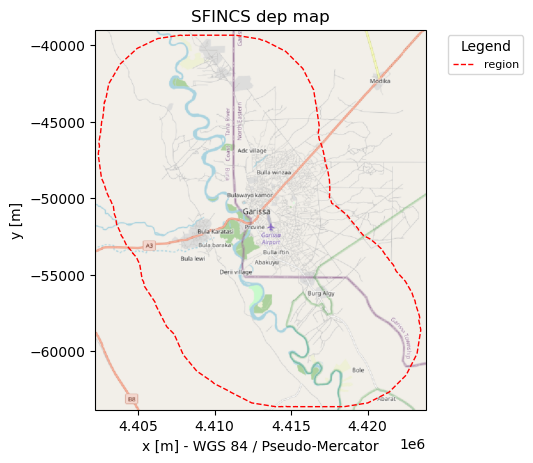

In [3]:
region_path = Path(r"data/1_static/regions/region_garissa_5km_buffer.geojson")

print("Region file found? ", os.path.isfile(region_path))

model.setup_grid_from_region(
    region={"geom":region_path},
    res=200,
    crs="3857",
)

print(model.config)

_ = model.plot_basemap(plot_region=True, bmap="osm")

### 4. Load in wanted elevation datasets and set the active cells:

In [4]:
datasets_dep = [{"elevtn": "srtm30"}]
model.setup_dep(datasets_dep=datasets_dep)

model.setup_mask_active(mask=region_path, zmin=-5, reset_mask=True)

2024-04-11 11:16:58,387 - prepare data catalog - rasterdataset - INFO - Reading srtm30 raster data from c:\Users\pjdeb\OneDrive\Documenten\Universiteit\CT 5\MDP\Git\MDP\SFINCS\data\1_static\srtm30\STRM30DEM_tana.tif
2024-04-11 11:16:58,477 - prepare data catalog - rasterdataset - DEBUG - Clip to [39.548, -0.571, 39.738, -0.352] (epsg:4326))
2024-04-11 11:16:58,808 - prepare data catalog - merge - DEBUG - Reprojection method of first dataset is: average
2024-04-11 11:16:58,817 - prepare data catalog - geodataframe - INFO - Reading  vector data from data\1_static\regions\region_garissa_5km_buffer.geojson
2024-04-11 11:16:58,842 - prepare data catalog - geodataframe - DEBUG - Clip intersects [39.548, -0.571, 39.737, -0.354] (EPSG:4326)
2024-04-11 11:16:58,871 - prepare data catalog - regulargrid - INFO - 0 gaps outside valid elevation range < 10.0 km2.
2024-04-11 11:16:58,874 - prepare data catalog - sfincs - INFO - Derive region geometry based on active cells.
2024-04-11 11:16:58,886 - p

### 5. Add river inflow/outflow points:

In [5]:
river_len = 100 # km
river_upa = 100 # km2
river_width = 150 # m

model.setup_river_inflow(
    hydrography="merit_hydro", 
    river_len=river_len, 
    river_upa=river_upa, 
    river_width=river_width, 
    keep_rivers_geom=True
)

2024-04-11 11:16:58,918 - prepare data catalog - rasterdataset - INFO - Reading merit_hydro raster data from c:\Users\pjdeb\OneDrive\Documenten\Universiteit\CT 5\MDP\Git\MDP\SFINCS\data\1_static\merit_hydro\{variable}.tif


2024-04-11 11:16:58,934 - prepare data catalog - io - WARNING - nodata value missing for c:\Users\pjdeb\OneDrive\Documenten\Universiteit\CT 5\MDP\Git\MDP\SFINCS\data\1_static\merit_hydro\uparea.tif
2024-04-11 11:16:58,948 - prepare data catalog - io - WARNING - nodata value missing for c:\Users\pjdeb\OneDrive\Documenten\Universiteit\CT 5\MDP\Git\MDP\SFINCS\data\1_static\merit_hydro\flwdir.tif
2024-04-11 11:16:58,980 - prepare data catalog - rasterdataset - DEBUG - Clip to [39.548, -0.571, 39.738, -0.352] (epsg:4326))
2024-04-11 11:17:03,579 - prepare data catalog - sfincs - INFO - Found 2 river inflow points.


### 6. Update mask with water level and outflow boundary cells - including use of polygons:

2024-04-11 11:17:03,630 - prepare data catalog - regulargrid - DEBUG - outflow (mask=3) boundary cells reset.


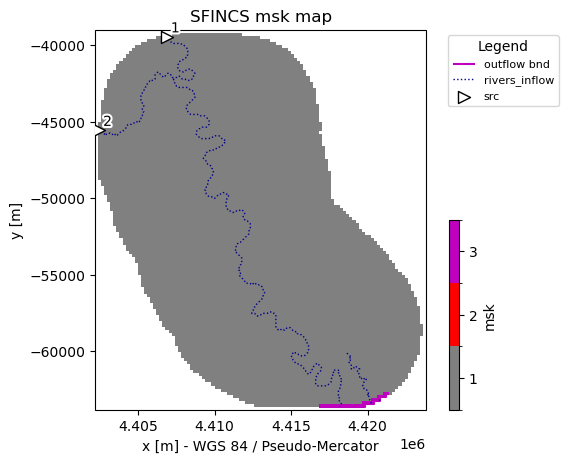

In [6]:
model.setup_mask_bounds(btype="outflow", zmax=135, reset_bounds=True)
# model.setup_mask_bounds(btype="waterlevel", include_mask="osm_coastlines", reset_bounds=True)

fig, ax = model.plot_basemap(variable="msk", plot_bounds=True)

### 7. Add spatially varying roughness data, burn river into DEM, create subgrid.

2024-04-11 11:17:04,113 - prepare data catalog - rasterdataset - INFO - Reading srtm30 raster data from c:\Users\pjdeb\OneDrive\Documenten\Universiteit\CT 5\MDP\Git\MDP\SFINCS\data\1_static\srtm30\STRM30DEM_tana.tif
2024-04-11 11:17:04,156 - prepare data catalog - rasterdataset - DEBUG - Clip to [39.548, -0.571, 39.738, -0.352] (epsg:4326))
2024-04-11 11:17:04,166 - prepare data catalog - rasterdataset - INFO - Reading vito raster data from c:\Users\pjdeb\OneDrive\Documenten\Universiteit\CT 5\MDP\Git\MDP\SFINCS\data\1_static\landuse\landuse_vito_tana1.tif
2024-04-11 11:17:04,193 - prepare data catalog - rasterdataset - DEBUG - Clip to [39.548, -0.571, 39.738, -0.352] (epsg:4326))
2024-04-11 11:17:04,196 - prepare data catalog - dataframe - INFO - Reading  csv data from c:\Users\pjdeb\anaconda3\envs\sfincs\lib\site-packages\hydromt_sfincs\data\lulc\vito_mapping.csv


The nodata value None is not in the reclass table.None will be used for the params.


2024-04-11 11:17:04,234 - prepare data catalog - subgrid - INFO - Number of regular cells in a block : 400
2024-04-11 11:17:04,235 - prepare data catalog - subgrid - INFO - Number of blocks in n direction    : 1
2024-04-11 11:17:04,236 - prepare data catalog - subgrid - INFO - Number of blocks in m direction    : 1
2024-04-11 11:17:04,239 - prepare data catalog - subgrid - INFO - Grid size of flux grid            : dx=200.0, dy=200.0
2024-04-11 11:17:04,240 - prepare data catalog - subgrid - INFO - Grid size of subgrid pixels       : dx=40.0, dy=40.0
2024-04-11 11:17:04,240 - prepare data catalog - subgrid - INFO - block 1/1 -- col 0:105 | row 0:121
2024-04-11 11:17:04,420 - prepare data catalog - subgrid - DEBUG - Processing subgrid tables for 8860 active cells..
2024-04-11 11:17:16,037 - prepare data catalog - utils - INFO - Building 2 overviews with average


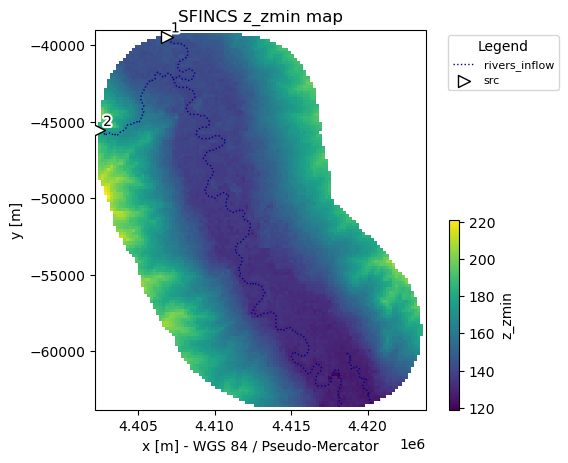

In [7]:
datasets_rgh = [{"lulc": "vito"}]

In [ ]:
model.setup_subgrid(
    datasets_dep=datasets_dep,
    datasets_rgh=datasets_rgh,
    # datasets_riv=datasets_riv,
    nr_subgrid_pixels=5,
    write_dep_tif=True,
    write_man_tif=False,
)
# uncomment to see the subgrid table variales
# sf.subgrid

# we can plot the 2D subgrid variables
_ = model.plot_basemap(
    variable="subgrid.z_zmin", plot_bounds=False, zoomlevel=12
)

### 8. Add spatially varying infiltration data:

In [8]:
model.setup_cn_infiltration("gcn250", antecedent_moisture="wet")

2024-04-11 11:17:16,480 - prepare data catalog - rasterdataset - INFO - Reading gcn250 raster data from c:\Users\pjdeb\OneDrive\Documenten\Universiteit\CT 5\MDP\Git\MDP\SFINCS\data\1_static\gcn250\{variable}.tif


2024-04-11 11:17:16,614 - prepare data catalog - rasterdataset - DEBUG - Clip to [39.548, -0.571, 39.738, -0.352] (epsg:4326))


### 9. Add an upstream discharge time-series as forcing:

2024-04-11 11:17:16,967 - prepare data catalog - dataframe - DEBUG - Slicing time dime (datetime.datetime(2023, 10, 1, 0, 0), datetime.datetime(2023, 11, 1, 0, 0))
2024-04-11 11:17:17,008 - prepare data catalog - model_api - WARNING - Replacing forcing: dis


<Axes: xlabel='date'>

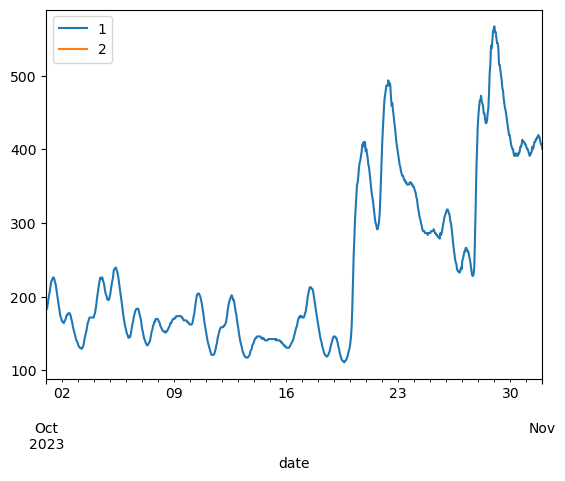

In [10]:
fpath_dis = Path(r"C:/Users/pjdeb/OneDrive/Documenten/Universiteit/CT 5/MDP/data_sens/wra/clean_data_mats/fixed_all_data_Garissa.csv")

discharge_garissa = pd.read_csv(fpath_dis, parse_dates=['date'], index_col='date')
discharge_garissa.index = pd.to_datetime(discharge_garissa.index, format="mixed")

start_date = pd.to_datetime(model.config["tstart"])
end_date = pd.to_datetime(model.config["tstop"])

###############################################################
discharge_garissa = discharge_garissa[(discharge_garissa.index >= start_date) & (discharge_garissa.index <= end_date)]
index = model.forcing["dis"].index
dis = pd.DataFrame(index=discharge_garissa.index, columns=index)

dis[1] = discharge_garissa["discharge[m3/s]"]

model.setup_discharge_forcing(timeseries=dis, buffer=1000)
dis.plot()

In [ ]:
# index = model.forcing["dis"].index

# time = pd.date_range(
#     model.config["tstart"],
#     model.config["tstop"]
# )

# dis = np.zeros((len(time), len(index)))

# dis[0:70, 0] = 10
# dis[100:107, 0] = 10
# dis[107:, 0] = 10

# dispd = pd.DataFrame(index=time, columns=index, data=dis)

# model.setup_discharge_forcing(timeseries=dispd, buffer=500)

# # model.forcing.keys()

# dispd.plot()

### 10. Add observation points (water level) and lines (discharge):

### 11. Save all files

In [12]:
model.write()
# Show created files in folder:
dir_list = os.listdir(model.root)
print(dir_list)

2024-04-11 11:17:17,507 - prepare data catalog - sfincs - INFO - Writing model data to c:\Users\pjdeb\OneDrive\Documenten\Universiteit\CT 5\MDP\Git\MDP\SFINCS\model\base_garissa
2024-04-11 11:17:17,510 - prepare data catalog - sfincs - DEBUG - Write binary map indices based on mask.
2024-04-11 11:17:17,513 - prepare data catalog - sfincs - DEBUG - Write binary map files: ['msk', 'dep', 'scs'].
2024-04-11 11:17:17,599 - prepare data catalog - sfincs - INFO - Write raster file(s) for grid to 'gis' subfolder
2024-04-11 11:17:17,713 - prepare data catalog - sfincs - INFO - Write geom files
2024-04-11 11:17:17,715 - prepare data catalog - sfincs - INFO - Write vector file(s) for geoms to 'gis' subfolder
2024-04-11 11:17:17,749 - prepare data catalog - sfincs - INFO - Write forcing files
2024-04-11 11:17:17,773 - prepare data catalog - sfincs - INFO - Write vector file(s) for forcing.dis to 'gis' subfolder
2024-04-11 11:17:17,807 - prepare data catalog - sfincs - WARNING - zsini not in state